In [1]:
from ipynb.fs.full.tokyo_NLP import *

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


station is repeated 3212 times.
tokyo is repeated 2125 times.
room is repeated 2012 times.
shinjuku is repeated 1510 times.
line is repeated 1205 times.
minutes is repeated 1090 times.
house is repeated 1009 times.
min is repeated 986 times.
walk is repeated 880 times.
asakusa is repeated 731 times.
area is repeated 707 times.
jr is repeated 688 times.
bed is repeated 687 times.
apartment is repeated 658 times.
airport is repeated 656 times.
mins is repeated 653 times.
ikebukuro is repeated 642 times.
access is repeated 630 times.
shibuya is repeated 592 times.
stores is repeated 550 times.
restaurants is repeated 549 times.
shopping is repeated 525 times.
kitchen is repeated 515 times.
ueno is repeated 505 times.
convenience is repeated 483 times.
rooms is repeated 472 times.
akihabara is repeated 468 times.
train is repeated 443 times.
hotel is repeated 423 times.
haneda is repeated 421 times.
floor is repeated 413 times.
bathroom is repeated 403 times.
ginza is repeated 374 times.
f

<Figure size 1200x1200 with 1 Axes>

In [2]:
df = pd.get_dummies(listings_clean)

In [3]:
df.shape

(10601, 182)

In [4]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [5]:
to_drop 

['property_type_Tent']

In [6]:
df = df.drop(columns=to_drop,axis=1) #property_type_Tent is highly correlated, drop it

In [7]:
numerical_col = ['accommodates','availability_30','availability_90','bathrooms','bedrooms','beds',
                 'cleaning_fee','extra_people','guests_included','host_active',
                'maximum_nights','minimum_nights','number_of_reviews','price','review_scores_accuracy',
                'review_scores_checkin','review_scores_cleanliness','review_scores_communication',
                'review_scores_location','review_scores_rating','review_scores_value','reviews_per_month',
                'security_deposit']

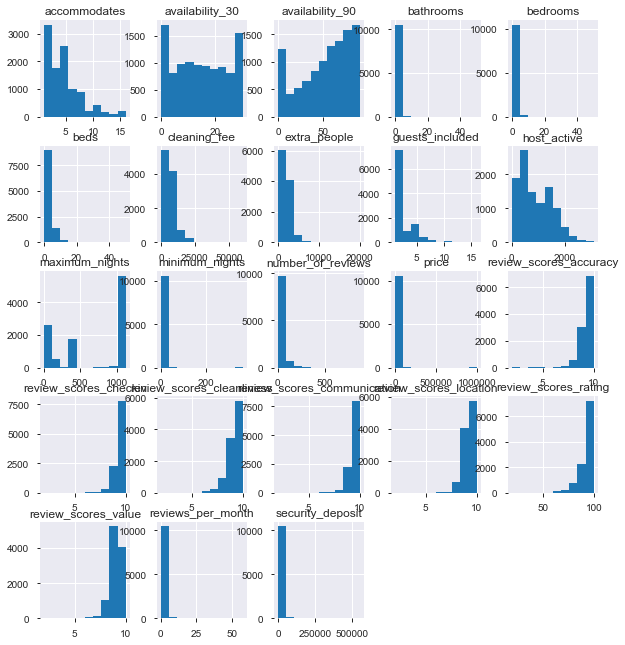

In [8]:
df[numerical_col].hist(figsize=(10,11));

In [9]:
# Log transforming columns because some features are highly skewed. 
numerical_col = [i for i in numerical_col if i not in ['availability_90','host_active',
                                                               'accommodates','availability_30',
                                                              ]] # Removing items not to be transformed

for col in numerical_col:
        df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
        df[col] = np.log(df[col])

In [10]:
#Target
y_price = df['price']
X_price = df.drop('price', axis=1)

In [12]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_price = pd.DataFrame(scaler.fit_transform(X_price), columns=list(X_price.columns))

In [13]:
from sklearn.model_selection import train_test_split
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
                                                           X_price, y_price, test_size=0.2, random_state=42)

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_price, y_train_price)
training_preds_xgb_reg = xgb_reg.predict(X_train_price)
val_preds_xgb_reg = xgb_reg.predict(X_test_price)

print("\nTraining MSE:", round(mean_squared_error(y_train_price, training_preds_xgb_reg),3))
print("Validation MSE:", round(mean_squared_error(y_test_price, val_preds_xgb_reg),3))

[01:16:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.285
Validation MSE: 0.345


In [15]:
print("\nTraining r2:", round(r2_score(y_train_price, training_preds_xgb_reg),3))
print("Validation r2:", round(r2_score(y_test_price, val_preds_xgb_reg),3))


Training r2: 0.627
Validation r2: 0.559


In [16]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_price.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
#ft_weights_xgb_reg

In [17]:
# Drop feature weights of 0 
ft_weights_xgb_reg = ft_weights_xgb_reg[(ft_weights_xgb_reg != 0).all(1)]

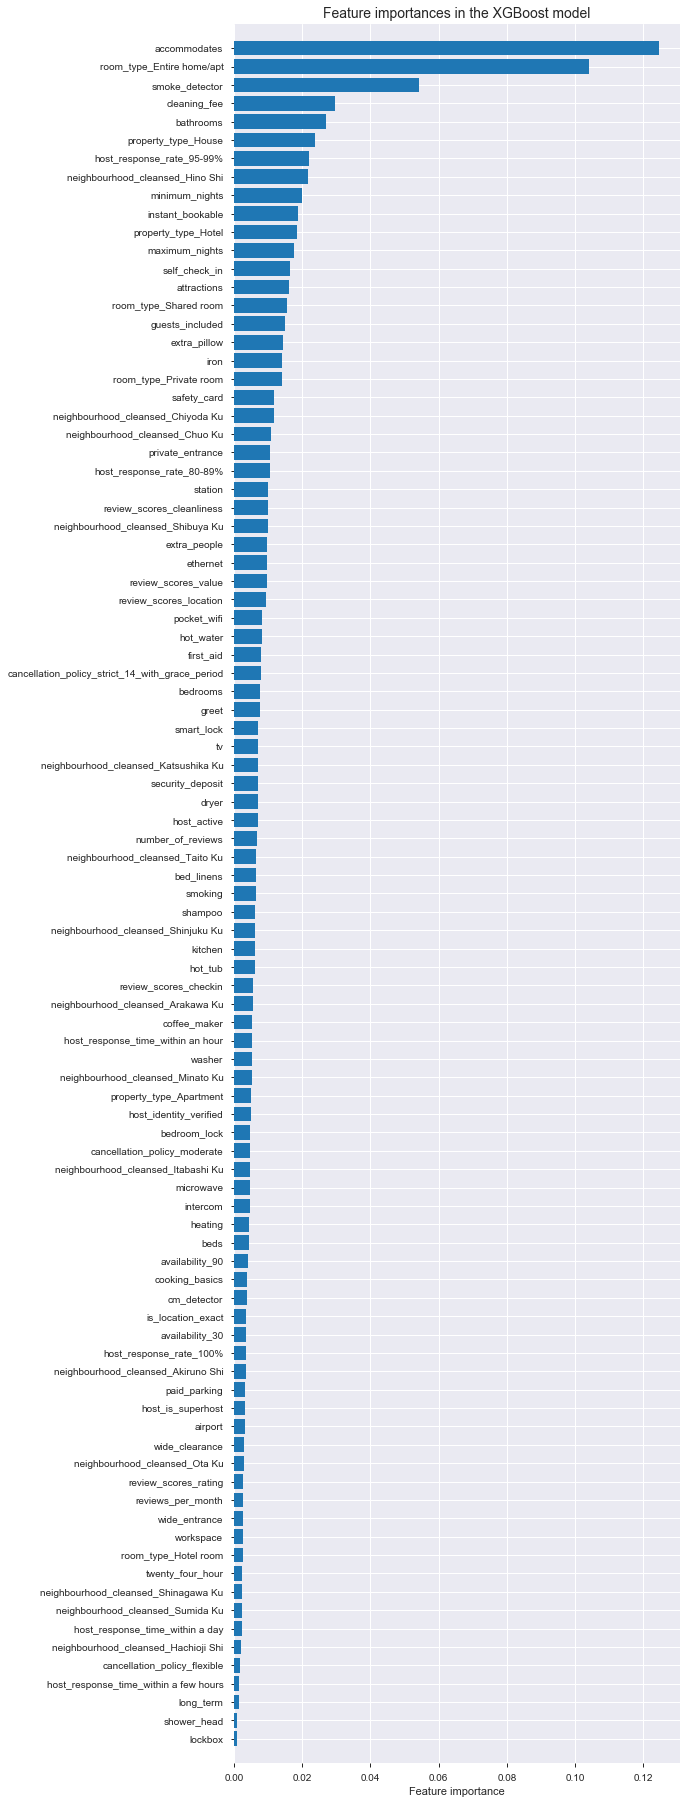

In [18]:
# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(8,32))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

### Lets use availability_30 as Target

In [19]:
#Target
y_30 = df['availability_30']
X_30 = df.drop(['availability_30','availability_90'],axis=1)

In [20]:
X_30 = pd.DataFrame(scaler.fit_transform(X_30), columns=list(X_30.columns))
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.2, random_state=42)

In [21]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_30, y_train_30)
training_preds_xgb_reg = xgb_reg.predict(X_train_30)
val_preds_xgb_reg = xgb_reg.predict(X_test_30)

print("\nTraining MSE:", round(mean_squared_error(y_train_30, training_preds_xgb_reg),3))
print("Validation MSE:", round(mean_squared_error(y_test_30, val_preds_xgb_reg),3))

[01:20:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 66.449
Validation MSE: 73.175


In [22]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_30.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

In [23]:
# Drop feature weights of 0 
ft_weights_xgb_reg = ft_weights_xgb_reg[(ft_weights_xgb_reg != 0).all(1)]

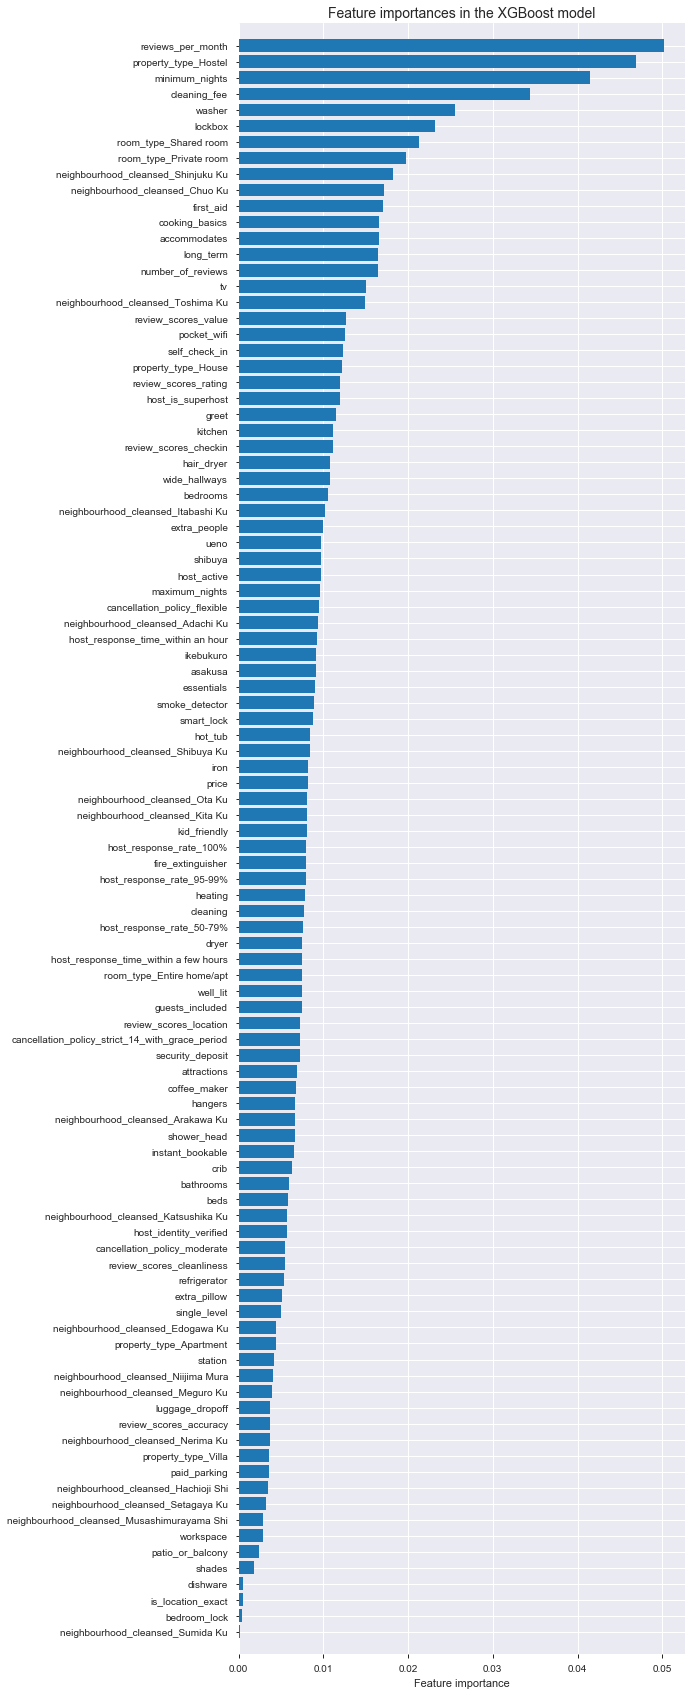

In [24]:
# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(8,30))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

### Availability_30 has a bigger MSE. 

### Lets use availability_90 as the Target

[01:24:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 549.229
Validation MSE: 583.289


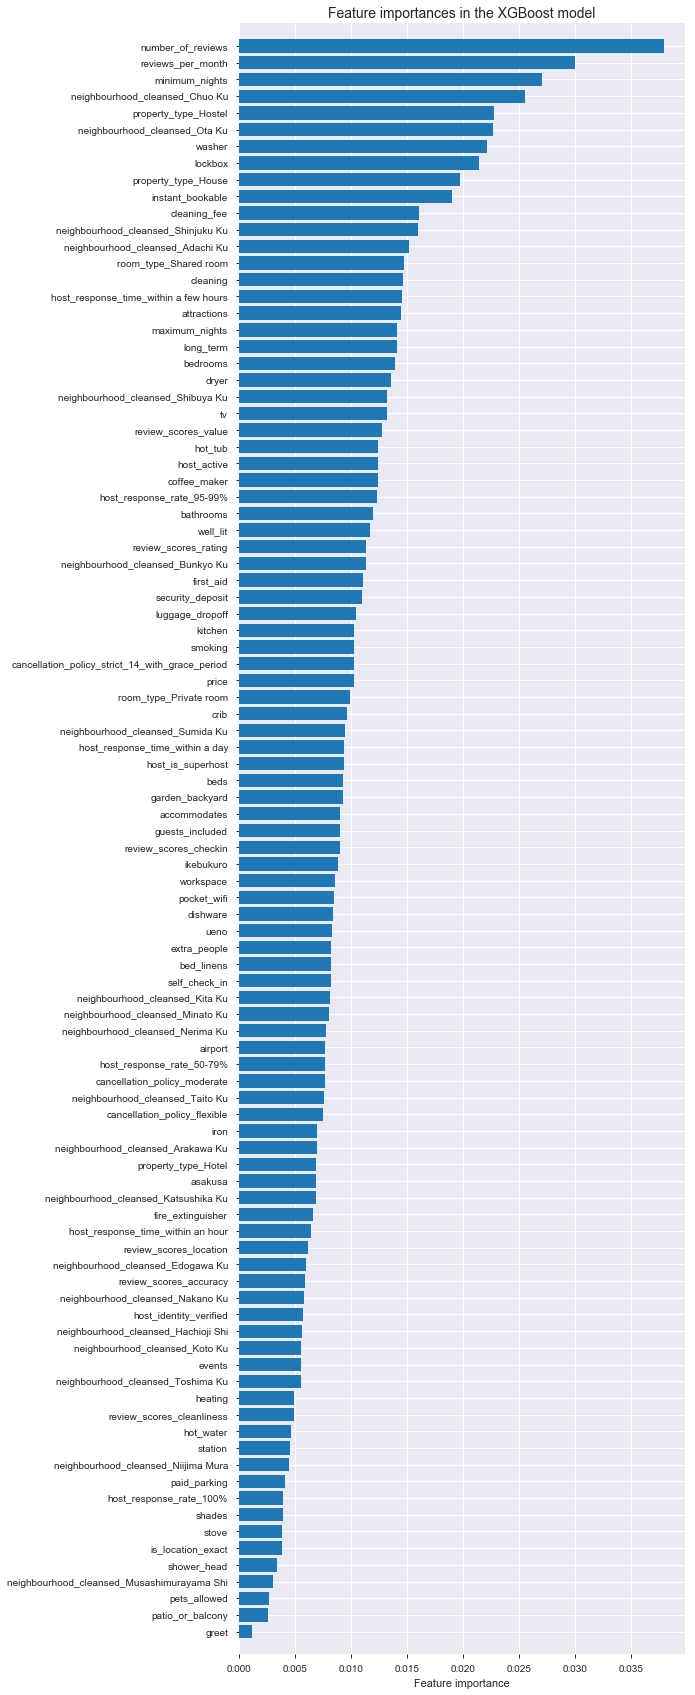

In [25]:
#Target
y_90 = df['availability_90']
X_90 = df.drop(['availability_30','availability_90'],axis=1)

X_90 = pd.DataFrame(scaler.fit_transform(X_90), columns=list(X_90.columns))
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90, y_90, test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_90, y_train_90)
training_preds_xgb_reg = xgb_reg.predict(X_train_90)
val_preds_xgb_reg = xgb_reg.predict(X_test_90)

print("\nTraining MSE:", round(mean_squared_error(y_train_90, training_preds_xgb_reg),3))
print("Validation MSE:", round(mean_squared_error(y_test_90, val_preds_xgb_reg),3))

ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_90.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
# Drop feature weights of 0 
ft_weights_xgb_reg = ft_weights_xgb_reg[(ft_weights_xgb_reg != 0).all(1)]

# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(8,30))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

### Availability_90 has a huge MSE. 

## Neural Net

In [26]:
from keras import models, layers, optimizers, regularizers

Using TensorFlow backend.


### Build Model without regularizers

In [27]:
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
                                                           X_price, y_price, test_size=0.2, random_state=42)

In [31]:
# Building the model
nn = models.Sequential()
nn.add(layers.Dense(128, input_shape=(X_train_price.shape[1],), activation='relu'))
nn.add(layers.Dense(256, activation='relu'))
nn.add(layers.Dense(256, activation='relu'))
nn.add(layers.Dense(512, activation='relu'))
nn.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               23168     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 254,081
Trainable params: 254,081
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# Training the model
nn_history = nn.fit(X_train_price,
                  y_train_price,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

Train on 7632 samples, validate on 848 samples
Epoch 1/150
7632/7632 [==============================] - 0s 58us/step - loss: 18.3059 - mean_squared_error: 18.3059 - val_loss: 7.3622 - val_mean_squared_error: 7.3622
Epoch 2/150
7632/7632 [==============================] - 0s 33us/step - loss: 3.1911 - mean_squared_error: 3.1911 - val_loss: 3.2521 - val_mean_squared_error: 3.2521
Epoch 3/150
7632/7632 [==============================] - 0s 33us/step - loss: 1.2005 - mean_squared_error: 1.2005 - val_loss: 2.2716 - val_mean_squared_error: 2.2716
Epoch 4/150
7632/7632 [==============================] - 0s 33us/step - loss: 0.7454 - mean_squared_error: 0.7454 - val_loss: 1.8883 - val_mean_squared_error: 1.8883
Epoch 5/150
7632/7632 [==============================] - 0s 32us/step - loss: 0.5557 - mean_squared_error: 0.5557 - val_loss: 1.6619 - val_mean_squared_error: 1.6619
Epoch 6/150
7632/7632 [==============================] - 0s 33us/step - loss: 0.4364 - mean_squared_error: 0.4364 - val_l

Epoch 50/150
7632/7632 [==============================] - 0s 51us/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.8704 - val_mean_squared_error: 0.8704
Epoch 51/150
7632/7632 [==============================] - 0s 50us/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.8847 - val_mean_squared_error: 0.8847
Epoch 52/150
7632/7632 [==============================] - 0s 43us/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.8916 - val_mean_squared_error: 0.8916
Epoch 53/150
7632/7632 [==============================] - 0s 35us/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.8970 - val_mean_squared_error: 0.8970
Epoch 54/150
7632/7632 [==============================] - 0s 49us/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.9016 - val_mean_squared_error: 0.9016
Epoch 55/150
7632/7632 [==============================] - 0s 39us/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.9092 - val_mean_squared_error: 0.909

7632/7632 [==============================] - 0s 35us/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.8244 - val_mean_squared_error: 0.8244
Epoch 100/150
7632/7632 [==============================] - 0s 39us/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.7674 - val_mean_squared_error: 0.7674
Epoch 101/150
7632/7632 [==============================] - 0s 32us/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.7683 - val_mean_squared_error: 0.7683
Epoch 102/150
7632/7632 [==============================] - 0s 32us/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.8035 - val_mean_squared_error: 0.8035
Epoch 103/150
7632/7632 [==============================] - 0s 42us/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.7645 - val_mean_squared_error: 0.7645
Epoch 104/150
7632/7632 [==============================] - 0s 57us/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.7676 - val_mean_squared_error: 0.7676
Epoch 

Epoch 148/150
7632/7632 [==============================] - 0s 60us/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.6769 - val_mean_squared_error: 0.6769
Epoch 149/150
7632/7632 [==============================] - 0s 33us/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.6534 - val_mean_squared_error: 0.6534
Epoch 150/150
7632/7632 [==============================] - 0s 36us/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.6554 - val_mean_squared_error: 0.6554


In [36]:
def nn_model_evaluation(model,X_train, X_test, y_train, y_test, skip_epochs=0,):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()

Training MSE: 0.084
Validation MSE: 0.3678

Training r2: 0.89
Validation r2: 0.5297


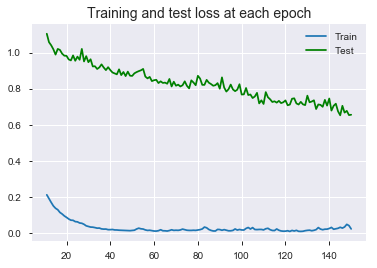

In [38]:
nn_model_evaluation(nn,X_train_price,X_test_price, y_train_price, y_test_price, skip_epochs=10)

### Build Model with regularizers

In [40]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train_price.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               23168     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 254,081
Trainable params: 254,081
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# Training the model
nn2_history = nn2.fit(X_train_price,
                  y_train_price,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

Train on 7632 samples, validate on 848 samples
Epoch 1/150
7632/7632 [==============================] - 1s 69us/step - loss: 85.0896 - mean_squared_error: 23.7870 - val_loss: 63.8989 - val_mean_squared_error: 7.2869
Epoch 2/150
7632/7632 [==============================] - 0s 35us/step - loss: 55.9968 - mean_squared_error: 3.8654 - val_loss: 50.1460 - val_mean_squared_error: 2.6103
Epoch 3/150
7632/7632 [==============================] - 0s 57us/step - loss: 45.4128 - mean_squared_error: 1.5390 - val_loss: 41.7238 - val_mean_squared_error: 1.3931
Epoch 4/150
7632/7632 [==============================] - 0s 38us/step - loss: 38.5555 - mean_squared_error: 0.8892 - val_loss: 35.8871 - val_mean_squared_error: 0.8619
Epoch 5/150
7632/7632 [==============================] - 0s 34us/step - loss: 33.5837 - mean_squared_error: 0.6564 - val_loss: 31.5208 - val_mean_squared_error: 0.7125
Epoch 6/150
7632/7632 [==============================] - 0s 40us/step - loss: 29.6139 - mean_squared_error: 0.53

7632/7632 [==============================] - 0s 43us/step - loss: 1.0448 - mean_squared_error: 0.3068 - val_loss: 1.0070 - val_mean_squared_error: 0.2874
Epoch 50/150
7632/7632 [==============================] - 0s 35us/step - loss: 1.0079 - mean_squared_error: 0.3056 - val_loss: 0.9622 - val_mean_squared_error: 0.2806
Epoch 51/150
7632/7632 [==============================] - 0s 44us/step - loss: 0.9689 - mean_squared_error: 0.3036 - val_loss: 0.9264 - val_mean_squared_error: 0.2804
Epoch 52/150
7632/7632 [==============================] - 0s 34us/step - loss: 0.9366 - mean_squared_error: 0.3043 - val_loss: 0.8987 - val_mean_squared_error: 0.2783
Epoch 53/150
7632/7632 [==============================] - 0s 37us/step - loss: 0.9129 - mean_squared_error: 0.3046 - val_loss: 0.8784 - val_mean_squared_error: 0.2851
Epoch 54/150
7632/7632 [==============================] - 0s 44us/step - loss: 0.8788 - mean_squared_error: 0.3020 - val_loss: 0.8455 - val_mean_squared_error: 0.2830
Epoch 55/15

7632/7632 [==============================] - 0s 36us/step - loss: 0.5651 - mean_squared_error: 0.2694 - val_loss: 0.5675 - val_mean_squared_error: 0.2722
Epoch 99/150
7632/7632 [==============================] - 0s 34us/step - loss: 0.5653 - mean_squared_error: 0.2694 - val_loss: 0.5486 - val_mean_squared_error: 0.2542
Epoch 100/150
7632/7632 [==============================] - 0s 35us/step - loss: 0.5623 - mean_squared_error: 0.2689 - val_loss: 0.5588 - val_mean_squared_error: 0.2636
Epoch 101/150
7632/7632 [==============================] - 0s 33us/step - loss: 0.5633 - mean_squared_error: 0.2675 - val_loss: 0.5516 - val_mean_squared_error: 0.2574
Epoch 102/150
7632/7632 [==============================] - 0s 34us/step - loss: 0.5618 - mean_squared_error: 0.2681 - val_loss: 0.5589 - val_mean_squared_error: 0.2647
Epoch 103/150
7632/7632 [==============================] - 0s 34us/step - loss: 0.5602 - mean_squared_error: 0.2670 - val_loss: 0.5509 - val_mean_squared_error: 0.2580
Epoch 1

Epoch 147/150
7632/7632 [==============================] - 0s 51us/step - loss: 0.5338 - mean_squared_error: 0.2514 - val_loss: 0.5351 - val_mean_squared_error: 0.2544
Epoch 148/150
7632/7632 [==============================] - 0s 45us/step - loss: 0.5330 - mean_squared_error: 0.2513 - val_loss: 0.5387 - val_mean_squared_error: 0.2545
Epoch 149/150
7632/7632 [==============================] - 0s 36us/step - loss: 0.5343 - mean_squared_error: 0.2512 - val_loss: 0.5240 - val_mean_squared_error: 0.2434
Epoch 150/150
7632/7632 [==============================] - 0s 38us/step - loss: 0.5314 - mean_squared_error: 0.2506 - val_loss: 0.5372 - val_mean_squared_error: 0.2547


Training MSE: 0.2423
Validation MSE: 0.3179

Training r2: 0.6827
Validation r2: 0.5936


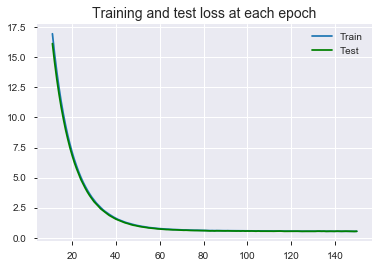

In [42]:
nn_model_evaluation(nn2,X_train_price,X_test_price, y_train_price, y_test_price, skip_epochs=10)

### Neural Net with Kernal Regularizers is best performing with lowest MSE and higest R2 score. 